# This notebook is to examine 'Kapoor_adjacency.csv' and 'Kapoor_TOM.csv' files.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load dfs

In [35]:
adj_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_adjacency.csv', index_col = 0)
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0, chunksize = 1000) # Just compare the first couple so no need to import all

In [178]:
ensemble_IDs = pd.Series(adj_df.columns)

In [179]:
ensemble_IDs.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\ensemble_IDs.csv')

In [38]:
for df in tom_df:
    tom_subset = df
    break

In [48]:
for j in range(1, 5):
    numerator = 1 +  

,ENSG00000237683,ENSG00000241860,ENSG00000228463,ENSG00000225972
ENSG00000237683,1.000000,0.000588,4.397223e-06,1.120192e-05
ENSG00000241860,0.000588,1.000000,2.809674e-04,7.323655e-06
ENSG00000228463,0.000004,0.000281,1.000000e+00,6.272579e-07
ENSG00000225972,0.000011,0.000007,6.272579e-07,1.000000e+00


# Use the method described in this stackoverflow post to calculate TOM from adjacency df.
<font size=5>https://stackoverflow.com/questions/56574729/how-to-compute-the-topological-overlap-measure-tom-for-a-weighted-adjacency-ma</font>

In [ ]:
A = adj_df.copy()
d = len(adj_df)
A.iloc[range(d), range(d)] = 0 
L = A @ A  # Could be done smarter by using the symmetry
K = A.sum(axis=1)

In [99]:
# Only loop the first 2 rows for simplicity
A_tom = np.zeros_like(A)
for j in range(1, d):  
    numerator = L.iloc[0, j] + A.iloc[0, j]
    denominator = min(K[0], K[j]) + 1 - A.iloc[0, j]
    A_tom[0, j] = numerator / denominator

In [102]:
for j in range(2, d):  
    numerator = L.iloc[1, j] + A.iloc[1, j]
    denominator = min(K[1], K[j]) + 1 - A.iloc[1, j]
    A_tom[1, j] = numerator / denominator
    
A_tom += A_tom.T # because the for loop only keeps going down so this step adds the df back for the symmetrical side of the data
A_tom[range(d), range(d)] = 1  # Set diagonal to 1 by default

## Plot pre-calculated TOM vs TOM calculated from adjacency df 

## Example 1: ENSG00000227232 weight with other 9 genes (left figure and right figure are identical)

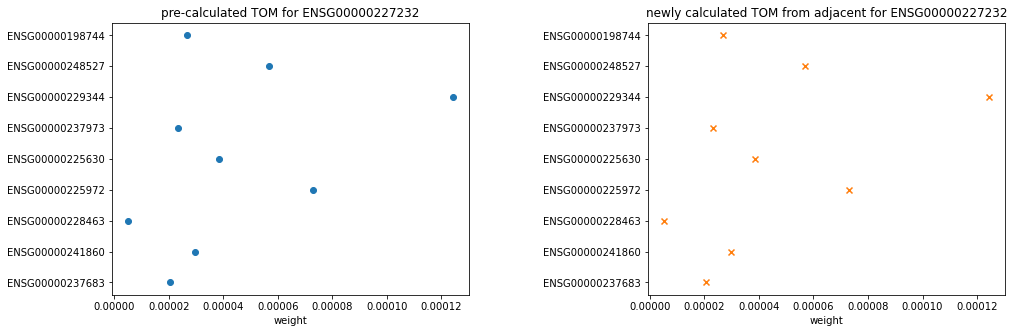

In [171]:
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.scatter(tom_subset.iloc[0,1:10], adj_df.columns[1:10], marker = 'o')
plt.title('pre-calculated TOM for ENSG00000227232')
plt.xlabel('weight')
plt.subplot(1,2,2)
plt.scatter(A_tom[0,1:10], adj_df.columns[1:10], marker = 'x', c = 'C1')
plt.title('newly calculated TOM from adjacent for ENSG00000227232')
plt.xlabel('weight')
plt.subplots_adjust(wspace =0.5)

## Overlay the above figures into 1

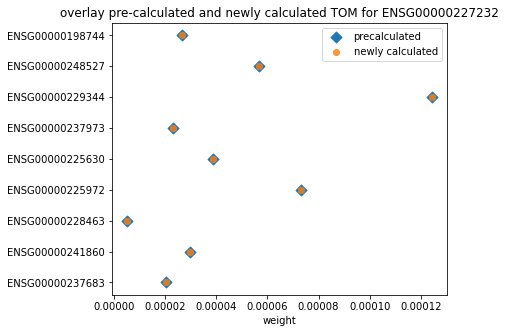

In [173]:
plt.figure(figsize = (6,5))
plt.scatter(tom_subset.iloc[0,1:10], adj_df.columns[1:10], marker = 'D', s = 60, label = 'precalculated')
plt.scatter(A_tom[0,1:10], adj_df.columns[1:10], marker = 'o', alpha = 0.8, label = 'newly calculated')
plt.title('overlay pre-calculated and newly calculated TOM for ENSG00000227232')
plt.legend()
plt.xlabel('weight');


## Example 2: ENSG00000237683 weight with other 8 genes (left figure and right figure are identical)

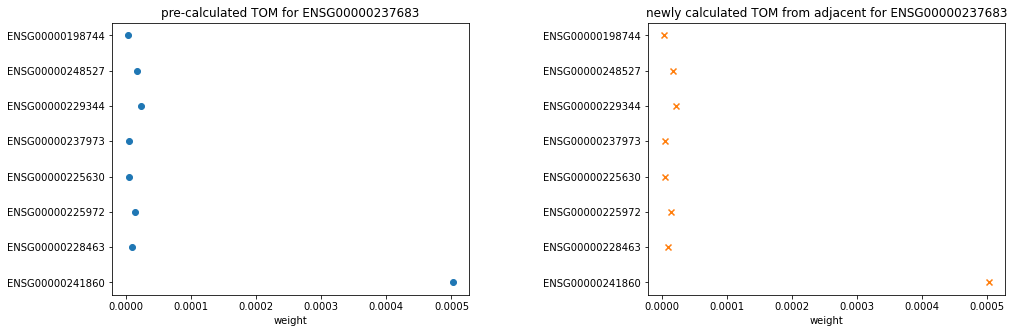

In [174]:
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.scatter(tom_subset.iloc[1,2:10], adj_df.columns[2:10], marker = 'o')
plt.title('pre-calculated TOM for ENSG00000237683')
plt.xlabel('weight')
plt.subplot(1,2,2)
plt.scatter(A_tom[1,2:10], adj_df.columns[2:10], marker = 'x', c = 'C1')
plt.title('newly calculated TOM from adjacent for ENSG00000237683')
plt.xlabel('weight')
plt.subplots_adjust(wspace =0.5);

## Overlay the above figures into 1

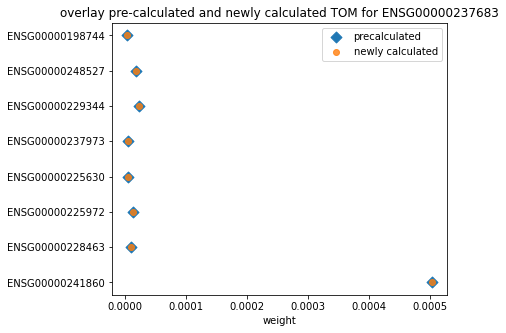

In [175]:
plt.figure(figsize = (6,5))
plt.scatter(tom_subset.iloc[1,2:10], adj_df.columns[2:10], marker = 'D', s = 60, label = 'precalculated')
plt.scatter(A_tom[1,2:10], adj_df.columns[2:10], marker = 'o', alpha = 0.8, label = 'newly calculated')
plt.title('overlay pre-calculated and newly calculated TOM for ENSG00000237683')
plt.legend()
plt.xlabel('weight');